Tangent Method
tensor([[ 341.5342,  545.1277,   67.1735,   54.6790],
        [ 627.1008,  234.6877,   54.2832,  158.2672],
        [ 373.4025,  456.6206,   83.8745,   96.9633],
        [ 338.8314,  497.2045,   65.4351,   48.6929],
        [ 677.3079,  815.1111,   53.4514,   80.9265],
        [ 939.1497,  838.7516,   52.6139,   63.3979],
        [ 510.7910, 1213.6265,   39.4469,   94.3416],
        [ 541.3601,  490.4954,   37.2179,   77.5659],
        [ 978.6887,  819.6984,   34.7731,   63.2751],
        [ 608.7960, 1151.9312,   41.2871,   84.5317],
        [ 729.8448,  188.3306,   55.7982,   95.2188],
        [ 471.0344,  531.5653,   37.9611,   59.8072],
        [ 720.0723,  430.5574,   30.4087,   70.2413],
        [1075.4231,  439.2360,   29.7422,   65.1944],
        [ 664.0393, 1130.3474,   24.2102,   56.8389],
        [ 529.3870,  214.0767,   71.9110,  139.0697],
        [ 421.4038, 1148.5388,   36.4782,   60.8569],
        [ 381.9771,  571.8722,   28.4095,   47.5673],
        [ 468

KeyError: (25, 1250)

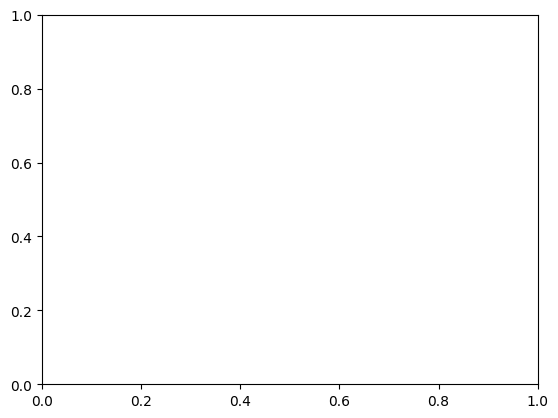

In [8]:
import time
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.join(current_dir, "..")
sys.path.append(parent_dir)

from tangent_method.API import tangent_method

import cv2
import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt
from ultralytics import YOLO
%matplotlib inline

current_coor = 0

# Function to calculate the new height while maintaining the aspect ratio
def resize_wh(orig_w, orig_h):
    # h, w, d = image.shape
    imgsz = 1280 # image size of yolo default is 640
    new_h = imgsz/orig_w * orig_h # new height with same ratio
    w = imgsz
    remainder = (new_h % 32) # YOLO need w,h that can divide by 32
    if remainder > 32/2:
        h = int(new_h - remainder + 32)
    else:
        h = int(new_h - remainder)
    return (w,h)


# Video input path
vdo_path = "testvid2.mov"
vdo = cv2.VideoCapture(vdo_path)

# YOLO model path
model_path = r"/home/kola/git-project/short_path/Search_2D/video/best.pt"
model = YOLO(model_path)

# Calculate new width and height while maintaining the aspect ratio
width = int(vdo.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vdo.get(cv2.CAP_PROP_FRAME_HEIGHT))
width, height = resize_wh(width, height)

# Get frames per second (fps) of the video
fps = vdo.get(cv2.CAP_PROP_FPS)

# Create a VideoWriter to save the output video
out = cv2.VideoWriter(
    filename="testoutput13.mp4",
    fourcc=cv2.VideoWriter_fourcc(*"mp4v"),
    fps=fps,
    frameSize=(width, height),
)

start_node = (25, 1250)  # (1100, 300) #(10,10) #testvid2-(25,1250) #testvid4-(25,25)
goal_node = (
    1700,
    25,
)  # (600, 800) #(1500,1200) #testvid2-(1700,25) #testvid4-(950,1275)

frame_count = 0
timels = []  # List to store timing information

while vdo.isOpened():
    # Check if the video is still open and can be read.

    # ret: A boolean value that indicates whether the frame was successfully read
    # frame: A NumPy array representing the image frame that was read from the video.
    ret, frame = vdo.read()

    if ret:
        # --- Object Detection Section ---
        t0_det = time.perf_counter()

        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # convert image to RGB color
        frame = cv2.resize(frame, (width, height))

        # Use a pre-trained model to predict objects in the frame.
        results = model.predict(frame, imgsz=(height, width), verbose=False)

        # Process each detected object result.
        for result in results:
            box = result.boxes.xywh  # Extract the bounding box information.

        # Measure the time taken for object detection.
        t1_det = time.perf_counter()

        if start_node == goal_node:
            # Append timing information and visualize the result.
            timels.append(
                [frame_count, t1_det - t0_det, t1_map - t0_map, t1_astar - t0_astar]
            )

            # Create an image with detected objects but without labels.
            final_img = result.plot(labels=False)

            # Draw circles around objects to represent obstacles.
            for coor in box:
                cv2.circle(
                    final_img,
                    (int(coor[0]), int(coor[1])),
                    obstacle_radius,
                    (0, 0, 255),
                    thickness=3,
                )
                cv2.circle(
                    final_img,
                    (int(coor[0]), int(coor[1])),
                    obstacle_radius + 50,
                    (255, 0, 0),
                    thickness=2,
                )

            # Draw a path and a circle representing the current position.
            # for i in range(len(path) - 1):
            #     cv2.line(
            #         final_img,
            #         (path[i][1], path[i][0]),
            #         (path[i + 1][1], path[i + 1][0]),
            #         (0, 255, 0),
            #         thickness=5,
            #     )

            final_img = cv2.circle(
                final_img, current_coor, 20, color=(255, 16, 240), thickness=-1
            )

            final_img = cv2.circle(
                final_img, start_node, 20, color=(255, 16, 240), thickness=-1
            )

            # Write the resulting image to an output file.
            out.write(final_img)
            # plt.imshow(cv2.circle(result.plot(labels=False), current_coor, 20, color=(255, 16, 240),thickness=-1))
            # plt.show()
            print("frame", frame_count)
            print(start_node)
            frame_count += 1
            clear_output(wait=True)
            continue

        # --- Path Planning Section ---

        # Update the path every 5 frames.
        if frame_count % 2 == 0:
            # map generation part
            t0_map = time.perf_counter()

            # Create obstacle and danger zones on the map.
            map = np.ones((height, width), dtype=np.uint16)
            obstacle_radius = 50
            danger_radius = 50
            thickness = -1

            for i in range(danger_radius):
                g_cost = ((obstacle_radius + 50 + i) * i) + 1
                for coor in box:
                    cv2.circle(
                        map,
                        (int(coor[0]), int(coor[1])),
                        obstacle_radius + danger_radius,
                        (g_cost),
                        thickness,
                    )
                danger_radius -= 1
            for coor in box:
                cv2.circle(
                    map, (int(coor[0]), int(coor[1])), obstacle_radius, 0, thickness
                )

            # Measure the time taken for map generation.
            t1_map = time.perf_counter()

            t0_astar = time.perf_counter()
            
            print("Tangent Method")
            print(box)
            print(start_node)
            print(goal_node)
            obs = []
            for coor in box:
                obs.append((coor[0], coor[1]))

            current_coor = tangent_method(
                box, [obstacle_radius] * len(box), start_node, goal_node
            )

            t1_astar = time.perf_counter()

            # Update the current position and visualize the result.
            final_img = result.plot(labels=False)

            # Draw circles around objects to represent obstacles.
            for coor in box:
                cv2.circle(
                    final_img,
                    (int(coor[0]), int(coor[1])),
                    obstacle_radius,
                    (0, 0, 255),
                    thickness=3,
                )
                cv2.circle(
                    final_img,
                    (int(coor[0]), int(coor[1])),
                    obstacle_radius + 50,
                    (255, 0, 0),
                    thickness=2,
                )

            # Draw the path and a circle representing the current position.
            # for i in range(len(path) - 1):
            #     cv2.line(
            #         final_img,
            #         (path[i][1], path[i][0]),
            #         (path[i + 1][1], path[i + 1][0]),
            #         (0, 255, 0),
            #         thickness=5,
            #     )
            final_img = cv2.circle(
                final_img, current_coor, 20, color=(255, 16, 240), thickness=-1
            )

            # Write the resulting image to an output file and update variables.
            out.write(final_img)
            # if len(path) >= 2:
            #     start_node = path[1]
            start_node = current_coor

            # plt.imshow(cv2.circle(result.plot(labels=False), current_coor, 20, color=(255, 16, 240),thickness=-1))
            # plt.show()
            print("frame", frame_count)
            # print(path)
            frame_count += 1
            clear_output(wait=True)
            continue

        timels.append(
            [frame_count, t1_det - t0_det, t1_map - t0_map, t1_astar - t0_astar]
        )

        # Create an image with detected objects but without labels.
        final_img = result.plot(labels=False)

        # Draw circles around objects to represent obstacles.
        for coor in box:
            cv2.circle(
                final_img,
                (int(coor[0]), int(coor[1])),
                obstacle_radius,
                (0, 0, 255),
                thickness=3,
            )
            cv2.circle(
                final_img,
                (int(coor[0]), int(coor[1])),
                obstacle_radius + 50,
                (255, 0, 0),
                thickness=2,
            )

        # Draw the path and a circle representing the current position.
        # for i in range(len(path) - 1):
        #     cv2.line(
        #         final_img,
        #         (path[i][1], path[i][0]),
        #         (path[i + 1][1], path[i + 1][0]),
        #         (0, 255, 0),
        #         thickness=5,
        #     )
        final_img = cv2.circle(
            final_img, current_coor, 20, color=(255, 16, 240), thickness=-1
        )

        # Write the resulting image to an output file.
        out.write(final_img)
        # plt.imshow(cv2.circle(result.plot(labels=False), current_coor, 20, color=(255, 16, 240),thickness=-1))
        # plt.show()

        print("frame", frame_count)
        # print(path)
        frame_count += 1
        clear_output(wait=True)
    else:
        break

# Release the output file.
out.release()


In [11]:
# print(timels)
import pandas as pd
df = pd.DataFrame(timels)
df.rename(columns = {0:'frame', 1:'detection_time', 2:'map_generation_time', 3:'a_star_time'}, inplace = True)
df.describe()

,frame,detection_time,map_generation_time,a_star_time
count,600.000000,600.000000,600.000000,600.000000
mean,299.500000,0.053671,0.055990,0.003302
std,173.349358,0.020188,0.004016,0.003752
min,0.000000,0.052071,0.047518,0.000141
25%,149.750000,0.052577,0.053376,0.000141
50%,299.500000,0.052774,0.056631,0.001818
75%,449.250000,0.052963,0.057389,0.004974
max,599.000000,0.547207,0.065038,0.015052
